Translate matlab files in `../indata`

In [1]:
import xarray as xr
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import scipy.io as sio
import seawater
import otis_tide_pred as otp
%matplotlib notebook
%load_ext autoreload
%autoreload 2


In [4]:
dat = sio.loadmat('gregg/KaenaRidge_axis.mat')
dx, head = seawater.dist(dat['lat_KaenaRidge_axis'][0], dat['lon_KaenaRidge_axis'][0])
print(180 - head)
print(np.shape(np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])))
dhead0 = 26.2516
U = (0 + 1j * 1) * np.exp(1j * dhead0 * np.pi / 180)
print(np.real(U))
print(np.imag(U))

[26.2516054]
(2, 3)
-0.4423137354582429
0.8968603901527682


[[-- -- -- ... -2654.265625 -2654.265625 -2654.265625]
 [-- -- -- ... -2654.2001953125 -2654.2001953125 -2654.265625]
 [-- -- -- ... -2648.28515625 -2650.25 -2654.265625]
 ...
 [-1207.0080080080015 -1207.703924284299 -1208.3998405606103 ...
  -4759.66357421875 -4755.083984375 -4752.5224609375]
 [-1207.0080080080015 -1207.703924284299 -1208.3998405606103 ...
  -4759.66357421875 -4756.60302734375 -4753.56494140625]
 [-1207.0080080080015 -1207.703924284299 -1208.3998405606103 ...
  -4760.56201171875 -4757.8662109375 -4757.8662109375]]
[20.75       20.75135501 20.75271003 ... 22.24728997 22.24864499
 22.25      ]
[-159.83333333 -159.83188496 -159.83043658 ... -157.50289675 -157.50144838
 -157.5       ]
1108
<xarray.Dataset>
Dimensions:  (lat: 1108, lon: 1612)
Coordinates:
  * lon      (lon) float64 -159.8 -159.8 -159.8 -159.8 -159.8 -159.8 -159.8 ...
  * lat      (lat) float64 20.75 20.75 20.75 20.75 20.76 20.76 20.76 20.76 ...
Data variables:
    depths   (lat, lon) float64 nan nan nan na

/Users/jklymak/anaconda3/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


<IPython.core.display.Javascript object>


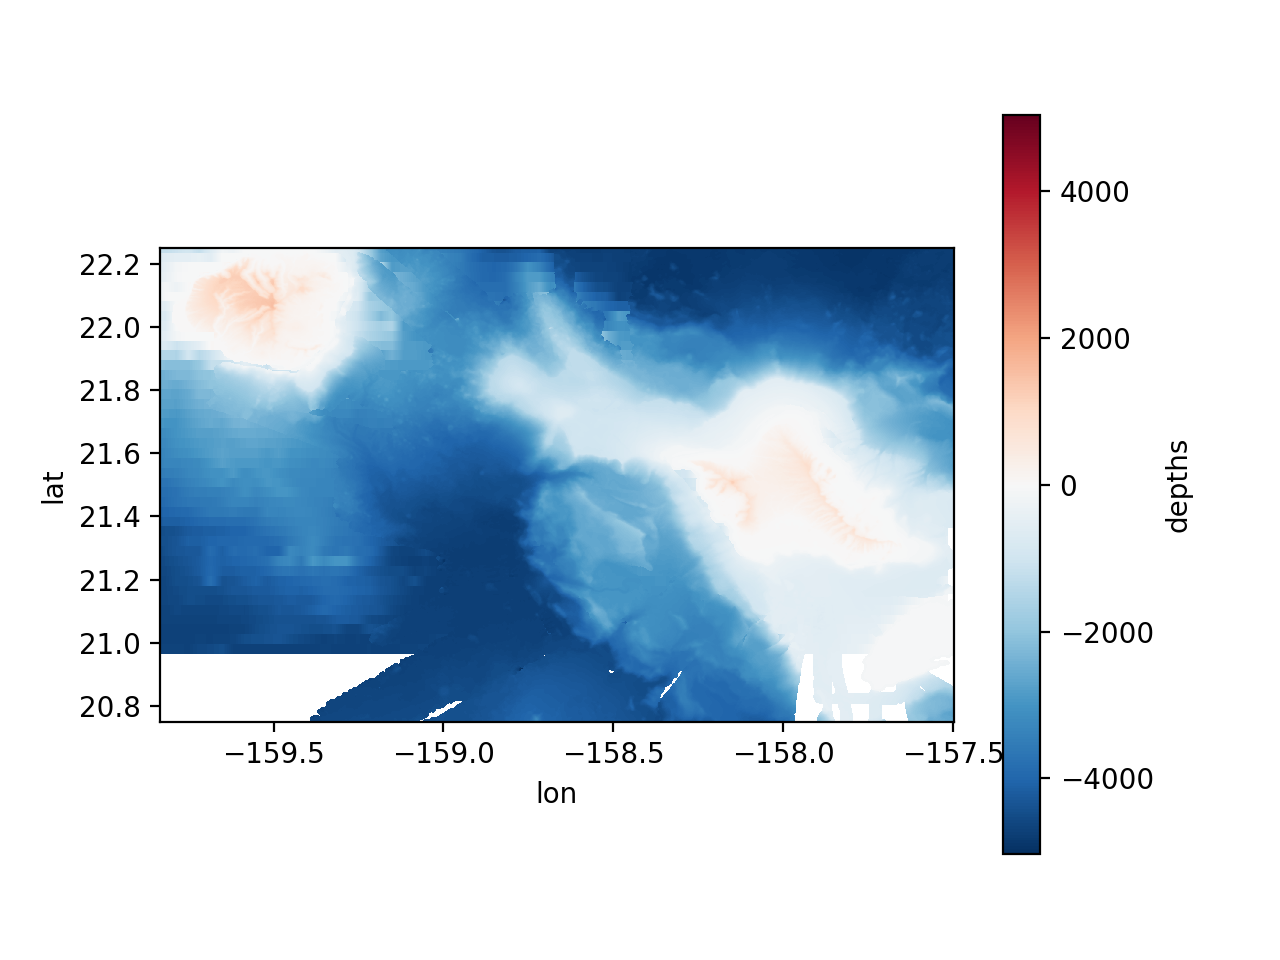

/Users/jklymak/anaconda3/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


In [4]:
data = sio.loadmat('../indata/oahuinterp.mat')
depths = np.ma.masked_invalid(data['depths'])
print(depths)
# make a netcdf...
print(data['lat'].flatten())
print(data['lon'].flatten())
print(len(data['lat'].flatten()))

ds = xr.Dataset({'depths': (['lat', 'lon'], depths)},
                coords = {'lon': ('lon', data['lon'].flatten()),
                          'lat': ('lat', data['lat'].flatten())})
print(ds)
fig, ax = plt.subplots()
xr.plot.pcolormesh(ds.depths, ax=ax)
ax.set_aspect(np.cos(21.6 * np.pi / 180))

In [5]:
crosssection = sio.loadmat('../indata/CrossSection.mat')
#print(crosssection.keys())
# put into ridge co-ordinate system:
cs = crosssection['cs']
cross = dict()
cross['lon'] = cs[0][0][2].flatten()
cross['lat'] = cs[0][0][3].flatten()
dist, bearing = seawater.dist(cross['lat'][[0, -1]], cross['lon'][[0, -1]])
ang0 = 90 - bearing
lon0 = -158.6013
lat0 = 21.7238

In [6]:
ss = xr.open_dataset('/Users/jklymak/smithsandwell82/smith_sandwell_topo_v8_2.nc')
print(ss)
inlon = ((ss.longitude>195) & (ss.longitude<215))
inlat = ((ss.latitude>10) & (ss.latitude < 35))
ss = ss.isel(longitude=inlon, latitude=inlat)

<xarray.Dataset>
Dimensions:    (latitude: 6336, longitude: 10800)
Coordinates:
  * longitude  (longitude) float32 0.01666667 0.05 0.08333334 0.1166667 0.15 ...
  * latitude   (latitude) float32 -72.0009 -71.99055 -71.98023 -71.96992 ...
Data variables:
    ROSE       (latitude, longitude) float64 ...
Attributes:
    title:                   Smith & Sandwell v. 8.2: 1/30-degree topography ...
    Conventions:             COARDS
    GFDL_NCIR_VER_NO:        1.0beta4
    unpacked_missing_value:  -32767.0
    institution:             University of California San Diego
    source:                  Uses satellite-measured gravity anomalies constr...
    history:                 26 Sep 2003: Dataset SS_2min_topo_8.2.nc FTPed f...
    references:              Smith, W. H. F. and D. T. Sandwell, Global Seafl...
    comment:                 Read accompanying smith_sandwell_COPYRIGHT and s...


In [7]:
def doubleinterp(x, y, z, xint, yint):
    """
    Interpolate z first in x and then in y.
    """
    m, n = np.shape(z)
    mnew = len(yint)
    nnew = len(xint)
    
    znew0 = np.zeros((m, nnew))
    for i in range(m):
        ind = np.isfinite(z[i, :])
        znew0[i, :] = np.interp(xint, x[ind], z[i, ind])
        
    znew = np.zeros((mnew, nnew))
    for j in range(nnew):
        ind = np.isfinite(znew0[:, j])
        znew[:, j] = np.interp(yint, y[ind], znew0[ind, j])
    
    return znew
 

    

In [8]:
## Fill in gaps of oahu data w/ SS
newdepths = doubleinterp(ss.longitude-360, ss.latitude, ss.ROSE, ds.lon, ds.lat)

In [9]:
m, n = np.shape(newdepths)
for i in range(m):
    bad = ~np.isfinite(ds.depths[i, :].values)
    ds.depths[i, bad] = newdepths[i, bad]

<IPython.core.display.Javascript object>


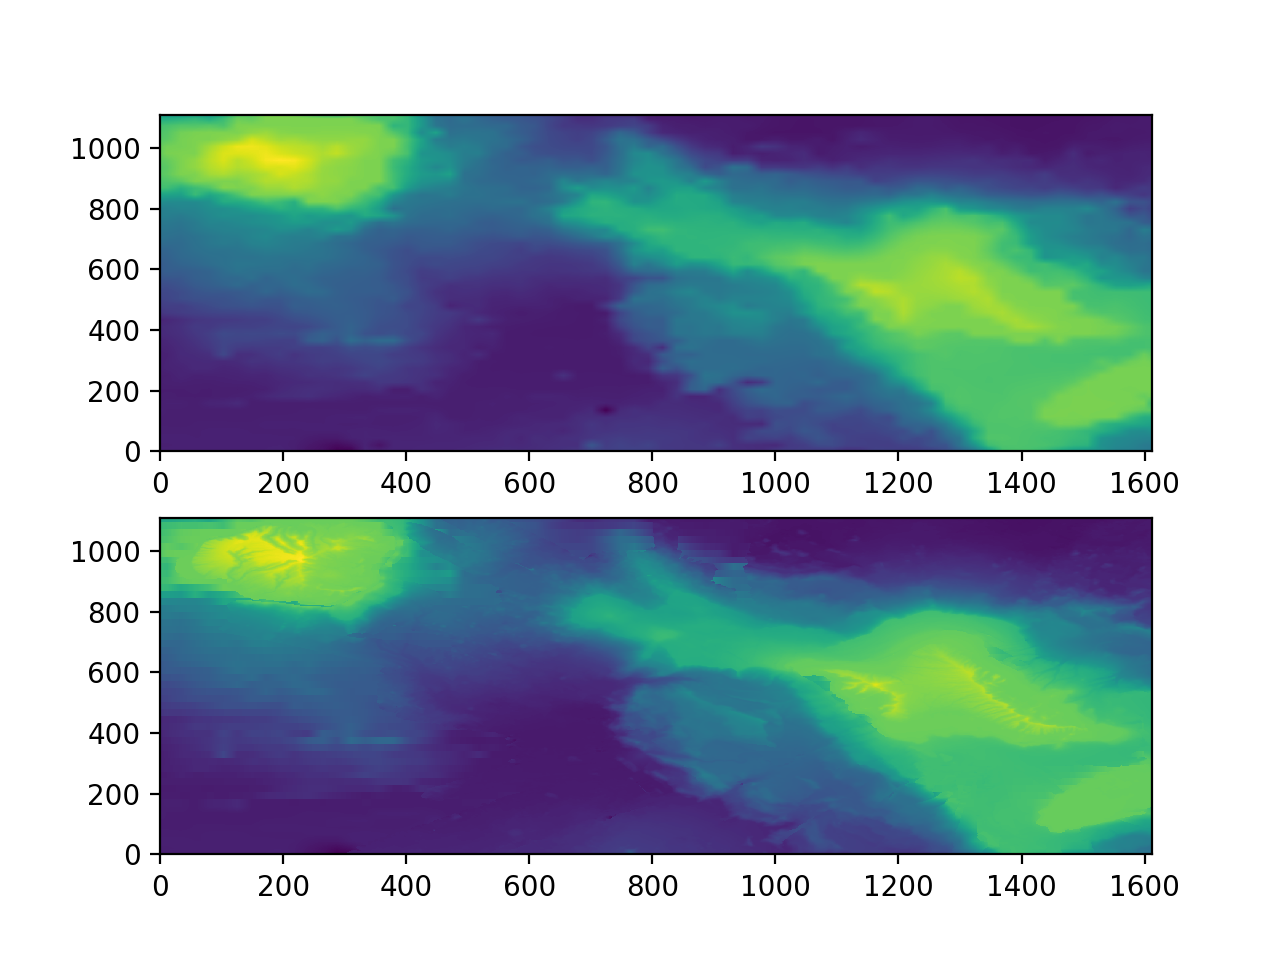

In [10]:
fig, ax = plt.subplots(2,1)
ax[0].pcolormesh(newdepths)
ax[1].pcolormesh(ds.depths)

In [11]:
ds.to_netcdf('../indata/OahuFilled.nc')
ss.to_netcdf('../indata/SmithSandwellNearHi.nc')

### Tz


In [99]:
data = sio.loadmat('../indata/Tz.mat')
ds = xr.Dataset({'T': (['z'], data['T'].flatten())},
                coords = {'z': ('z', data['z'].flatten())})
print(ds)
ds.to_netcdf('../indata/TempProfile.nc')


<xarray.Dataset>
Dimensions:  (z: 100)
Coordinates:
  * z        (z) float64 46.67 91.78 135.3 177.3 217.8 256.7 294.0 329.8 ...
Data variables:
    T        (z) float64 25.84 22.24 19.23 17.38 15.63 14.35 13.19 12.23 ...


## As in `gendata.py`

<IPython.core.display.Javascript object>


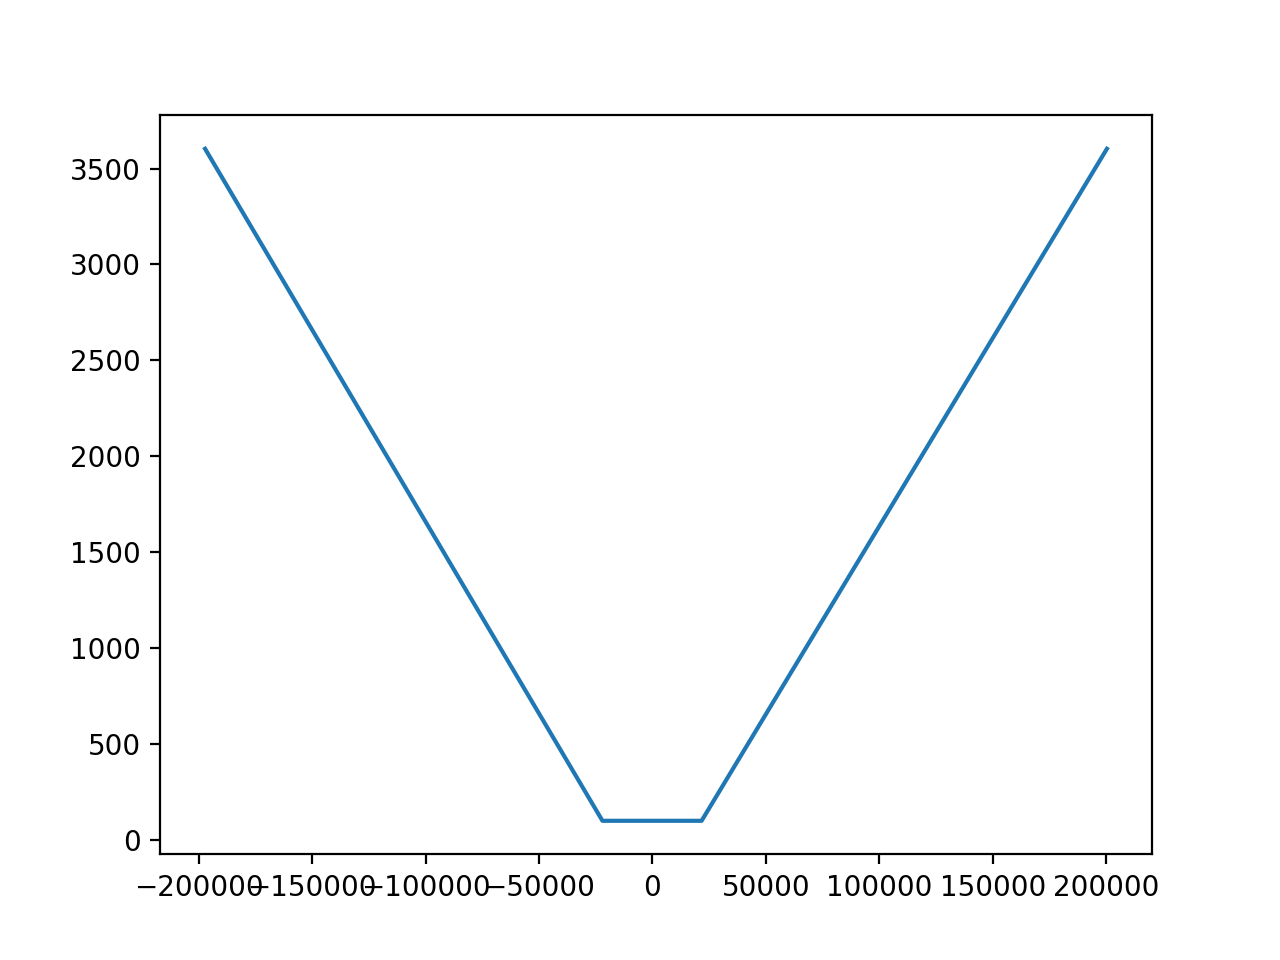

<IPython.core.display.Javascript object>


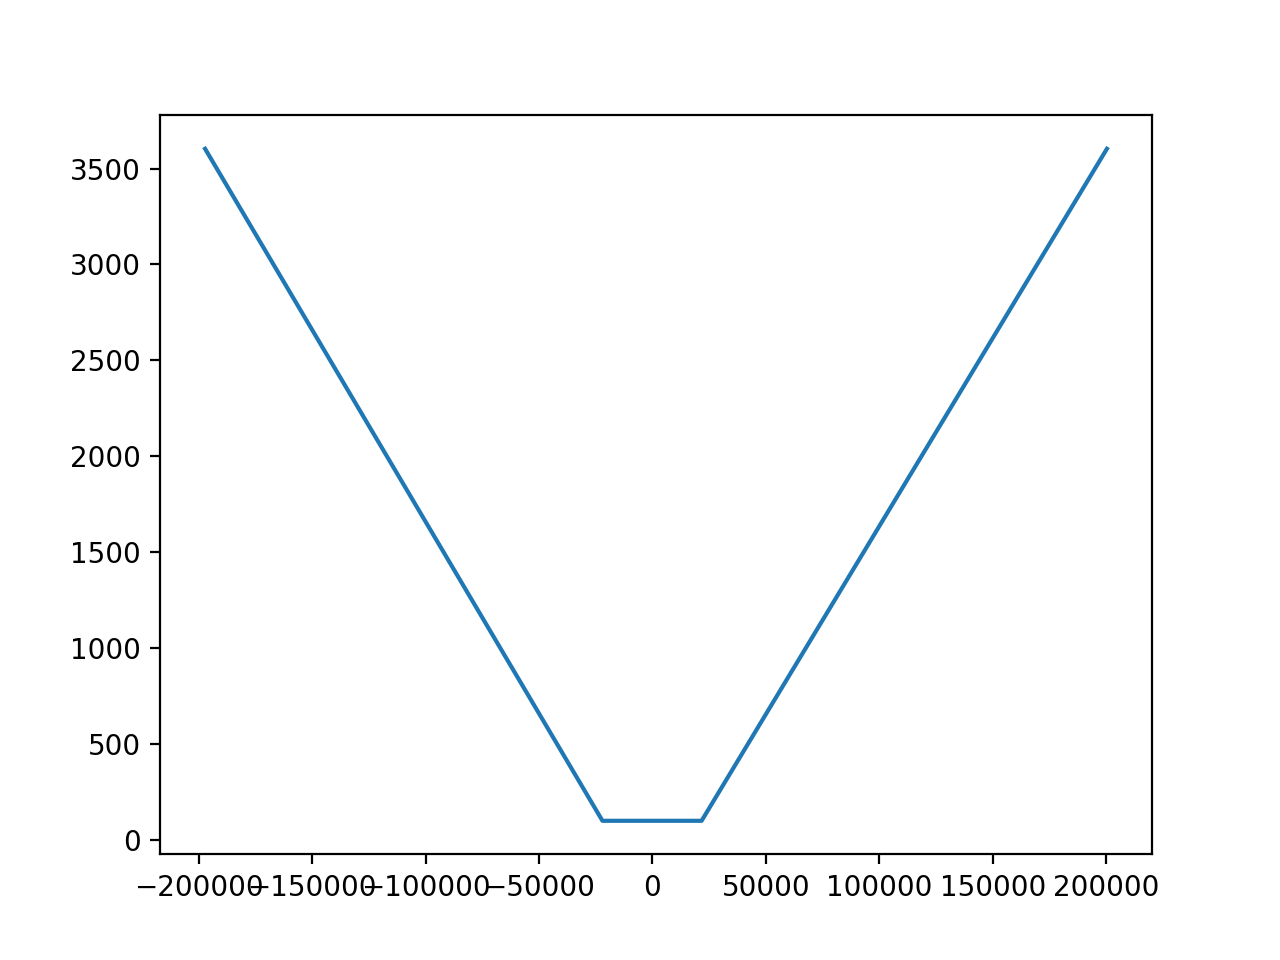

In [13]:
nx = 16 * 50  # 8*64
ny = 16 * 50 # 8*64
innerw = int(440 / 2)
# FLIP!
lon0 = -158-37.77/60;
lat0 =21+40.780/60;
mpernm = 1852
def ll2xy(lon, lat):
    x = (lon - lon0) * mpernm * 60 * np.cos(lat0 * np.pi / 180)
    y = (lat - lat0) * mpernm * 60
    return x, y
def xy2ll(x, y):
    lon = lon0 + x / (mpernm * 60 * np.cos(lat0 * np.pi / 180))
    lat = lat0 + y / (mpernm * 60)
    return lon, lat


ds = xr.open_dataset('../indata/OahuFilled.nc')
ds['x'], ds['y'] = ll2xy(ds['lon'], ds['lat'])

ss = xr.open_dataset('../indata/SmithSandwellNearHi.nc')
ss['x'], ss['y'] = ll2xy(ss['longitude'] - 360, ss['latitude'])

dx = np.ones(nx)
inner = range(int(nx/2) - innerw, int(nx/2) + innerw)
dx[inner] = 100
for i in range(inner[-1], nx):
    dx[i] = dx[i-1] * 1.02
for i in range(inner[0], -1, -1):
    dx[i] = dx[i+1] * 1.02

x = np.cumsum(dx)
x = x - np.mean(x)
fig, ax = plt.subplots()
ax.plot(x, dx)
    
dy = np.ones(ny)
inner = range(int(ny/2) - innerw, int(ny/2) + innerw)
dy[inner] = 100
for i in range(inner[-1], ny):
    dy[i] = dy[i-1] * 1.02
for i in range(inner[0], -1, -1):
    dy[i] = dy[i+1] * 1.02

y = np.cumsum(dy)
y = y - np.mean(y)
fig, ax = plt.subplots()
ax.plot(y, dy)
    
topo0 = doubleinterp(ss.x, ss.y, ss.ROSE, x, y)

In [14]:
iny = (ds.y.values[0] <= y) & ( y <= ds.y.values[-1])
inx = (ds.x.values[0] <= x) & (x <= ds.x.values[-1])
print(len(np.where(inx)[0]))
topo = topo0.copy()
toponew = doubleinterp(ds.x, ds.y, ds.depths, x[inx], y[iny])
for nn, i in enumerate(np.where(inx)[0]):
    topo[iny, i] = toponew[:, nn]
## Done here!


742


<IPython.core.display.Javascript object>


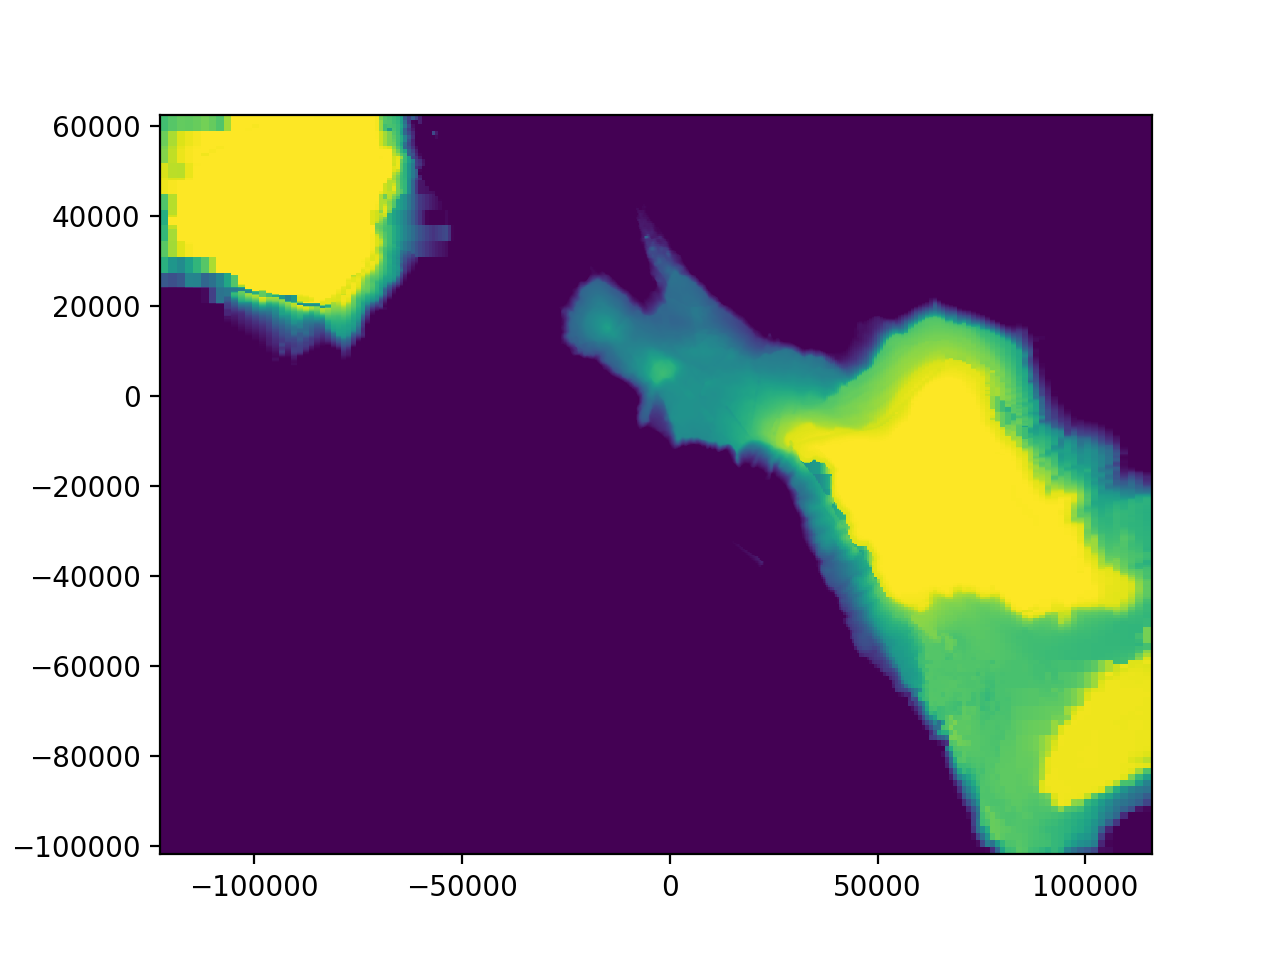

In [15]:
fig, ax = plt.subplots()
ax.pcolormesh(x[inx], y[iny], topo[iny, :][:, inx], vmin=-2000, vmax=0)

<IPython.core.display.Javascript object>


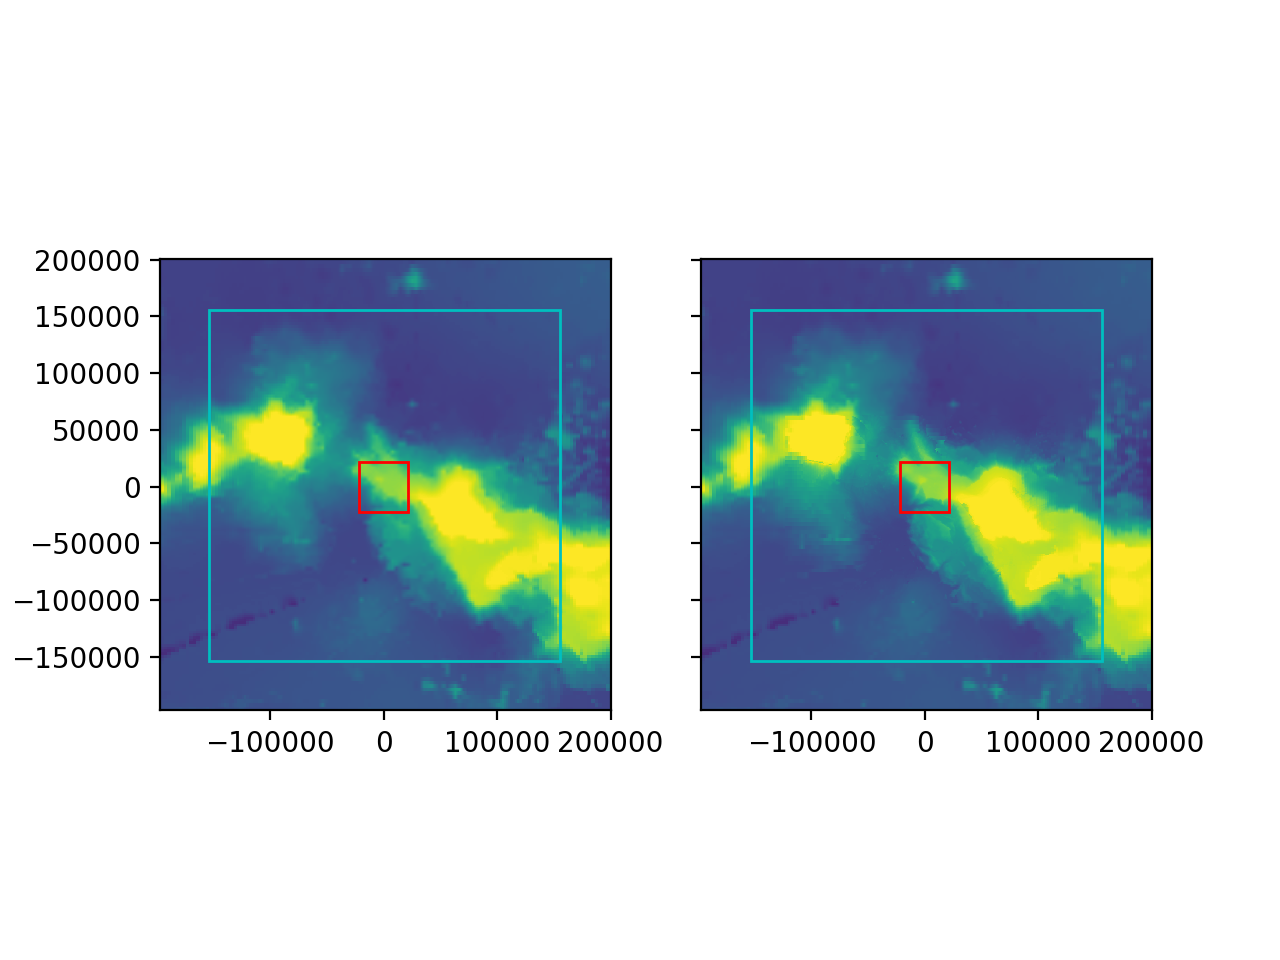

In [81]:
fig, axs = plt.subplots(1 ,2, sharex=True, sharey=True)
#ax[0].pcolormesh(ds.x, ds.y, ds.depths, rasterized=True)
#ax[1].pcolormesh(ss.x, ss.y, ss.ROSE,  rasterized=True)

tp = topo0
for ax in axs:
    
    ax.pcolormesh(x, y, tp,  rasterized=True, vmin=-6000, vmax=0)
    #ax.contour(x, y, topo0,  levels=[-4000, -3000, -2000, -1000, 0], colors='k')
    ind = np.where(np.diff(x) == 100)[0]
    dx = x[ind[-1]] - x[ind[0]]
    dy = y[ind[-1]] - y[ind[0]]
    rec = mpatches.Rectangle((x[ind[0]], y[ind[0]]), dx, dy, facecolor='none', edgecolor='r') 
    ax.add_artist(rec)
    indx = np.arange(14, len(x)-14)
    indy = np.arange(14, len(y)-14)
    dx = x[indx[-1]] - x[indx[0]]
    dy = y[indy[-1]] - y[indy[0]]
    rec = mpatches.Rectangle((x[indx[0]], y[indy[0]]), dx, dy, facecolor='none', edgecolor='c') 
    ax.add_artist(rec)
    
    ax.set_aspect(1)
    tp = topo

5204.164509656034


<IPython.core.display.Javascript object>


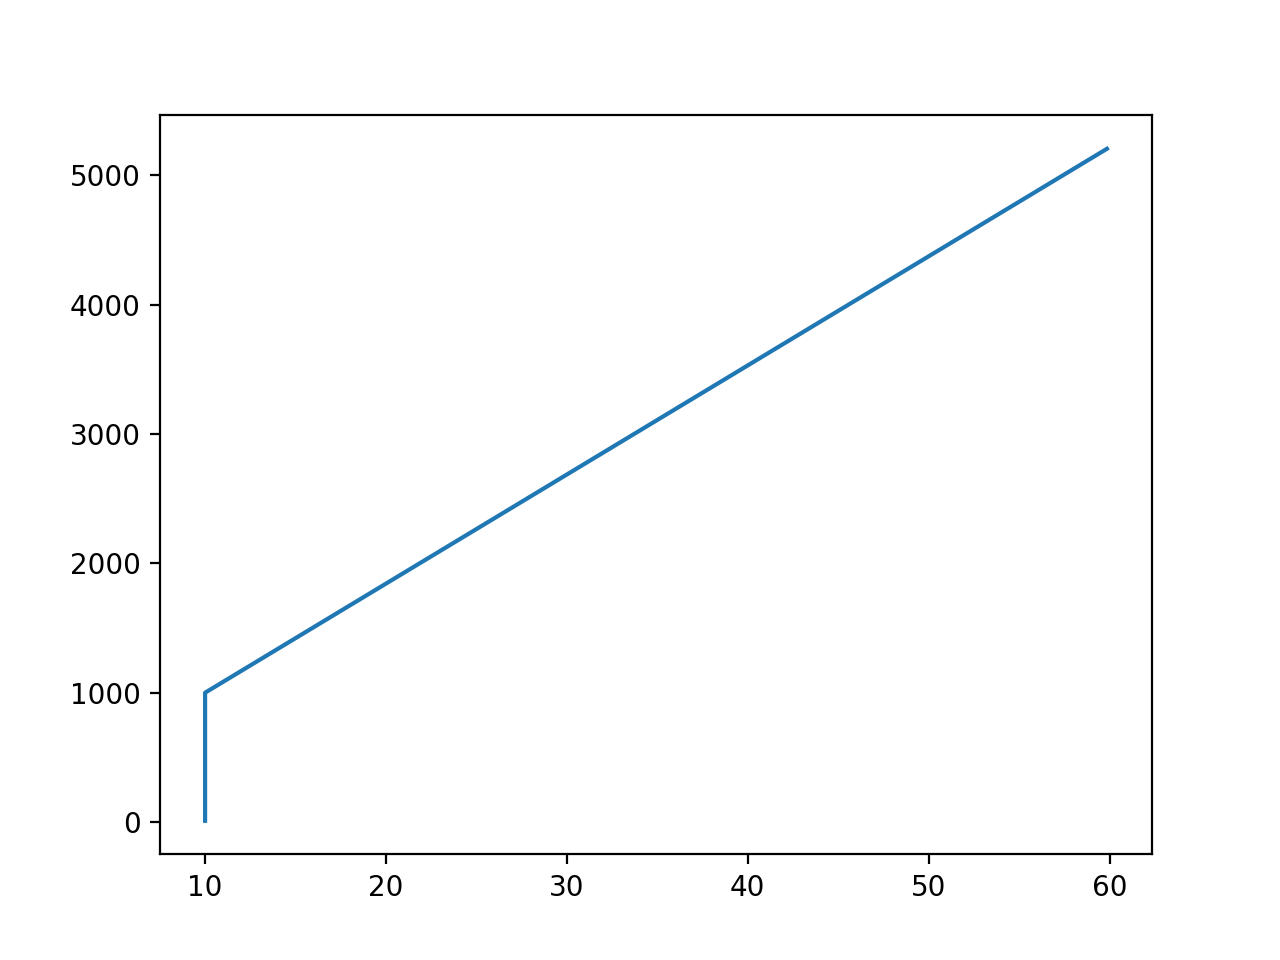

In [93]:
Hmax = 5200
dz = np.ones(250) * 10
for i in range(100, 250):
    dz[i] = dz[i-1] * 1.012
print(np.sum(dz))
fig, ax = plt.subplots()
ax.plot(dz, np.cumsum(dz))

## T0

In [104]:
tp = xr.open_dataset('../indata/TempProfile.nc')
z = np.cumsum(dz)
print(tp.z)
T0 = np.interp(z, tp.z.values, tp['T'].values)
print(T0)

<xarray.DataArray 'z' (z: 100)>
array([  46.666667,   91.777778,  135.333333,  177.333333,  217.777778,
        256.666667,  294.      ,  329.777778,  364.      ,  396.666667,
        427.777778,  457.333333,  485.333333,  511.777778,  536.666667,
        560.      ,  581.777778,  602.      ,  620.666667,  637.777778,
        653.333333,  667.333333,  679.777778,  690.666667,  700.      ,
        710.      ,  720.      ,  730.      ,  740.      ,  750.      ,
        760.      ,  770.      ,  780.      ,  790.      ,  800.      ,
        810.      ,  820.      ,  830.      ,  840.      ,  850.      ,
        860.      ,  870.      ,  880.      ,  890.      ,  900.      ,
        910.      ,  920.      ,  930.      ,  940.      ,  950.      ,
        960.      ,  970.      ,  980.      ,  990.      , 1000.      ,
       1010.      , 1020.      , 1030.      , 1040.      , 1050.      ,
       1060.      , 1070.      , 1080.      , 1090.      , 1100.      ,
       1110.      , 1120.      ,

## Tides

In [69]:
# get the latitude and longitude of the sponge middle...
spongew = 15
# south:
ind = 7
X, Y = np.meshgrid(x, y)
lons, lats = xy2ll(x, y[ind] + 0 *x)
dates = np.arange(np.datetime64('2002-08-15'), np.datetime64('2002-09-22'), dtype='datetime64[h]')
h, u, v, depths = otp.tide_pred('../indata/DATA/Model_haw', lons, lats, dates)

ind = -7
X, Y = np.meshgrid(x, y)
lons, lats = xy2ll(x, y[ind] + 0 *x)
dates = np.arange(np.datetime64('2002-08-15'), np.datetime64('2002-09-22'), dtype='datetime64[h]')
h, u, v, depths = otp.tide_pred('../indata/DATA/Model_haw', lons, lats, dates)
print(np.shape(u))


Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...
Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...
(912, 800)


In [67]:
# get the latitude and longitude of the sponge middle...
spongew = 15
# south:
ind = 7
X, Y = np.meshgrid(x, y)
lons, lats = xy2ll(x[ind] + 0 *y, y)
h, u, v, depths = otp.tide_pred('../indata/DATA/Model_haw', lons, lats, dates)

if 0:
    ind = -7
    X, Y = np.meshgrid(x, y)
    lons, lats = xy2ll(x[ind] + 0 *y, y)
    h, u, v, depths = otp.tide_pred('../indata/DATA/Model_haw', lons, lats, dates)



Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


<IPython.core.display.Javascript object>


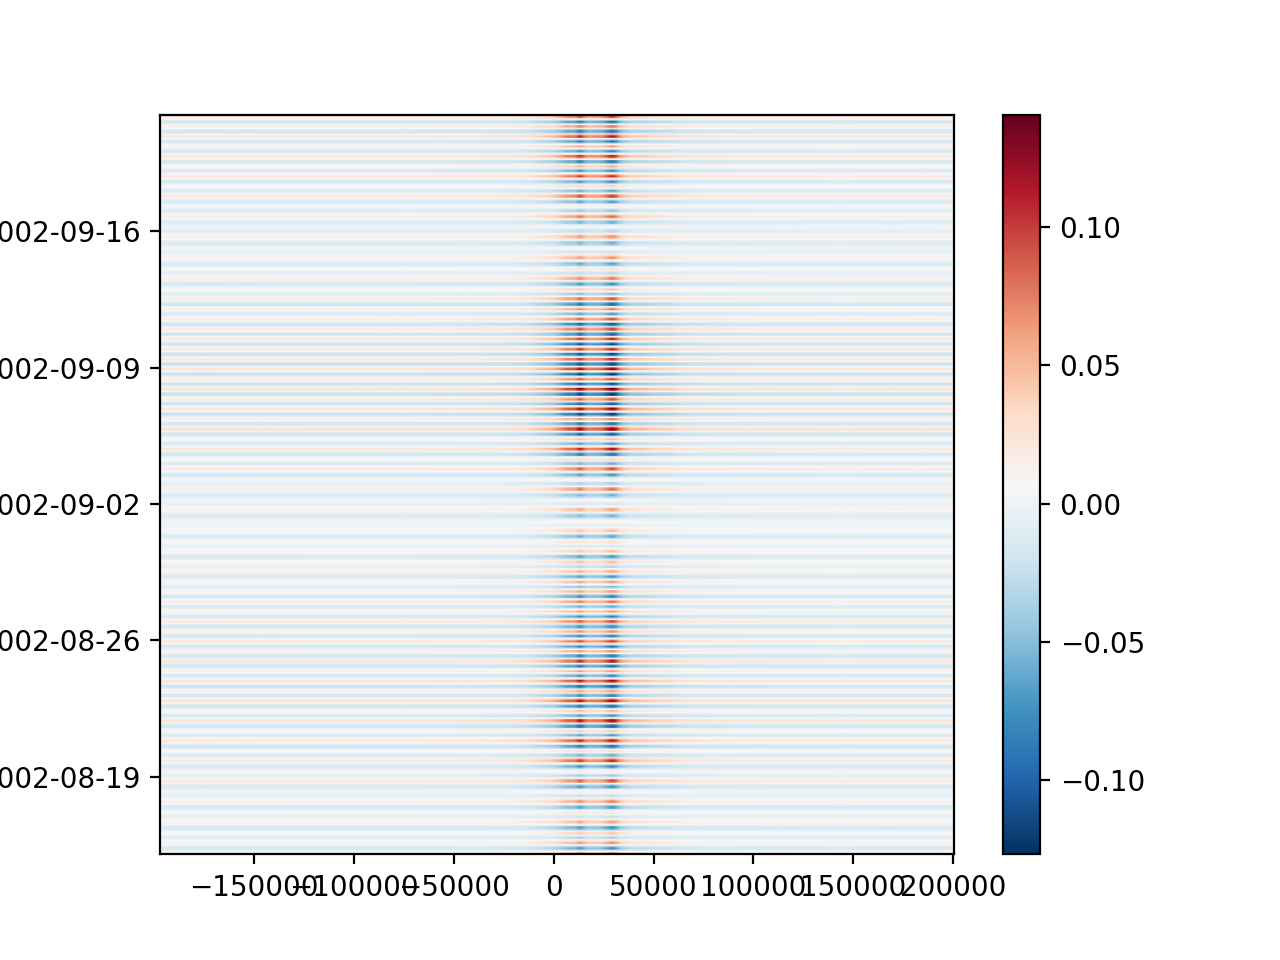

In [68]:
badx = np.where(depths<200)[0]
u[:, badx] = 0.
fig, ax = plt.subplots()
#u = np.ma.masked_where(np.abs(u)>2., u)
pcm = ax.pcolormesh(y, dates, u, cmap='RdBu_r')
fig.colorbar(pcm)

<IPython.core.display.Javascript object>


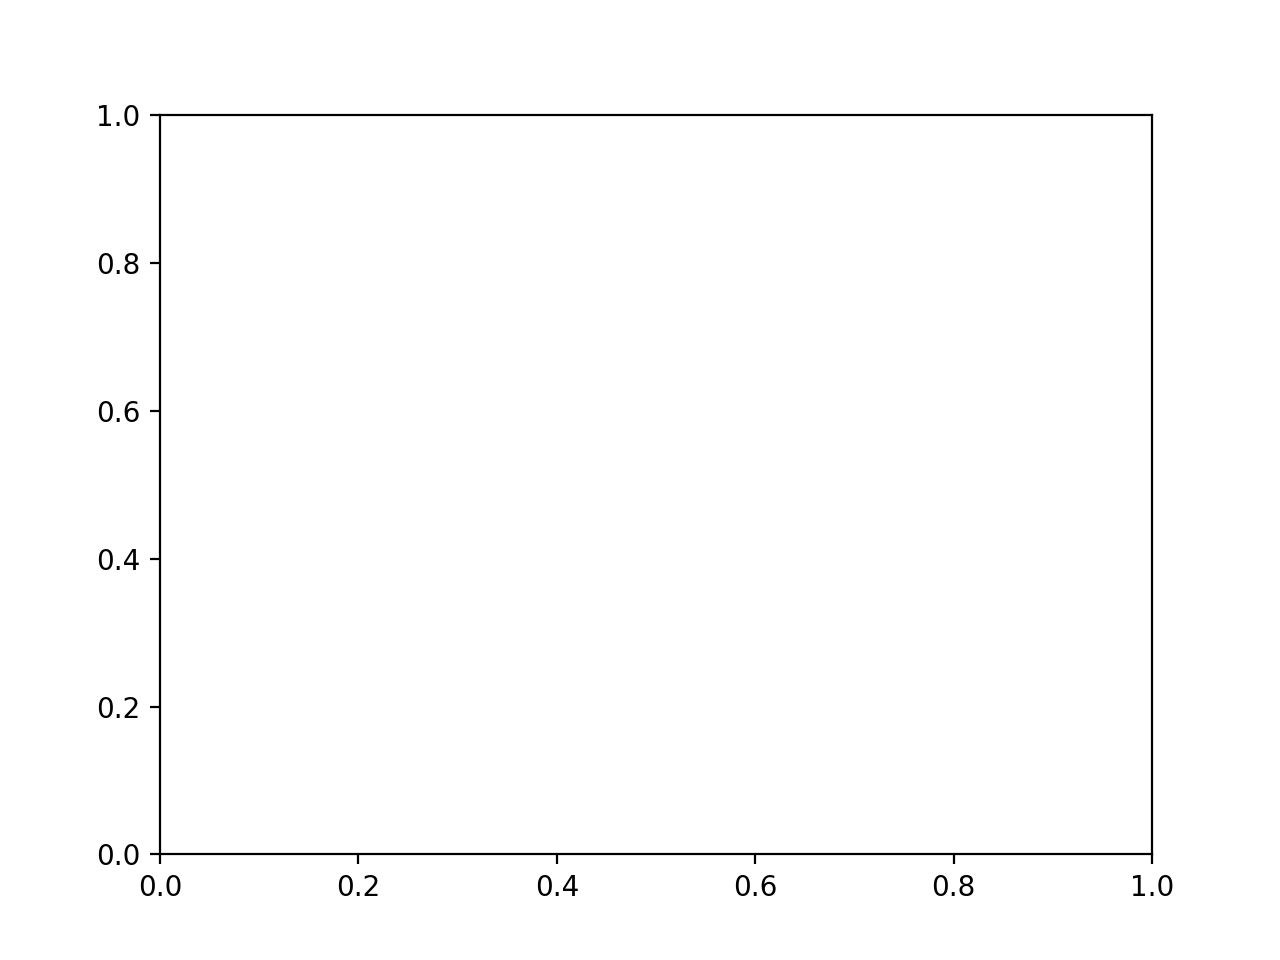

ValueError: x and y must have same first dimension, but have shapes (800,) and (481, 901)

In [61]:
fig, ax = plt.subplots()
ax.plot(y, depths)

In [ ]:
dat = sio.